In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

from numpy.linalg import eig

In [2]:
# Visualizing graphs

matplotlib.rcParams['figure.figsize'] = (8, 8)
options = {
    "width": 1,
    "edge_color" : "gray",
    "node_size" : 40
}

# gets n colors from colormap but ignores edge values
def get_color_map(n, cmap = cm.jet):
    return ['#{:02x}{:02x}{:02x}'.format(*c) for c in (cmap(np.linspace(0.05, 0.95, n)) * 255).astype(int)]

def draw(G, colors=None):
    nx.draw_spring(G, **options)
    plt.show()
    
def draw_clusters(G, labels):
    k = np.max(labels) + 1
    color_map = get_color_map(k)
    node_colors = [ color_map[x] for x in labels ]
    
    nx.draw_spring(G, **options, node_color = node_colors)
    plt.show()


In [3]:
d1_unc = pd.read_csv('./competition/D1-UNC.csv', header=None).to_numpy()
d2_unc = pd.read_csv('./competition/D2-UNC.csv', header=None).to_numpy()
d3_unc = pd.read_csv('./competition/D3-UNC.csv', header=None).to_numpy()

In [4]:
d1_k = pd.read_csv('./competition/D1-K=2.csv', header=None).to_numpy()
d2_k = pd.read_csv('./competition/D2-K=7.csv', header=None).to_numpy()
d3_k = pd.read_csv('./competition/D3-K=12.csv', header=None).to_numpy()

In [5]:
# Gets number of cluster based on eigenvalues
# Assumes eigenvalues are sorted ascending
def get_cluster_num(vals):
    # We assuming that there should be at least 2 clusters
    # and at most <node count>/2 clusters
    min_k = 1
    max_k = int(vals.shape[0] / 2)
    vals2 = vals[min_k : max_k]
    
    # The biggest influence has dropout between consecutive eigenvalues
    diff = np.diff(vals2)
    # We are also intoducing penalty based on value of eigenvalue
    # in comparison to biggest eigenvalue considered
    penalty = vals2 / vals2[-1]
    penalty = penalty[0:-1]
    grade = diff - penalty
    
    k = np.argmax(grade)
    return k + 1 + min_k

In [6]:
def kmeans_alg(points, k, max_it = 1000):
    n = points.shape[0]
    m = points.shape[1]
    labels = np.zeros(n, dtype=np.int32)
    prev_labels = labels.copy()
    centroids = points[np.random.choice(points.shape[0], size=k, replace=False), :]
    for it in range(max_it):
        for i, p in zip(range(n), points):
            min_dist = np.sqrt(np.sum(np.power(centroids[0] - p, 2)))
            min_num = 0
            for num, c in zip(range(k), centroids):
                dist = np.sqrt(np.sum(np.power(c - p, 2)))
                if dist < min_dist:
                    min_dist = dist
                    min_num = num
            labels[i] = min_num
        prev_labels = labels.copy()
        for i in range(len(centroids)):
            if np.sum(labels == i) != 0:
                centroids[i] = np.mean(points[labels == i], axis=0)
    return labels

In [7]:
def spectral_clustering(adj_matrix):
    diag_matrix = np.diag(adj_matrix.sum(axis=1))
    laplacian_matrix = diag_matrix - adj_matrix

    vals, vecs = np.linalg.eig(laplacian_matrix)

    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]

    k = get_cluster_num(vals)
    
    labels = kmeans_alg(vecs[:, 1:k], k)
    k = len(np.unique(labels))
    return labels, k

In [8]:
def summarize_clustering(adj_matrix):
    labels, k = spectral_clustering(adj_matrix)
    G = nx.from_numpy_array(adj_matrix)
    draw_clusters(G, labels)
    print(f"Number of clusters: {k}")
    return labels

In [9]:
def test_network(g, save = False, file_out = None):
    start = time.time()
    g_labels = summarize_clustering(g)
    end = time.time()
    print(f"Time: {end - start}")
    if save:
        df = pd.DataFrame(g_labels)
        df.to_csv(file_out, header=False, sep=',')

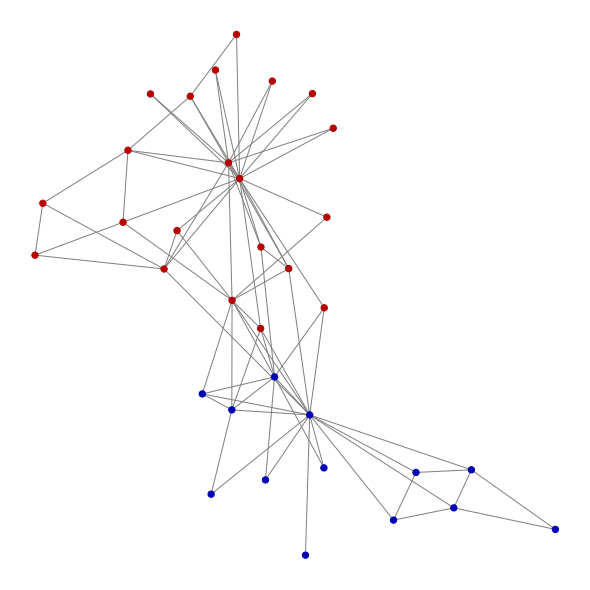

Number of clusters: 2
Time: 0.6411893367767334


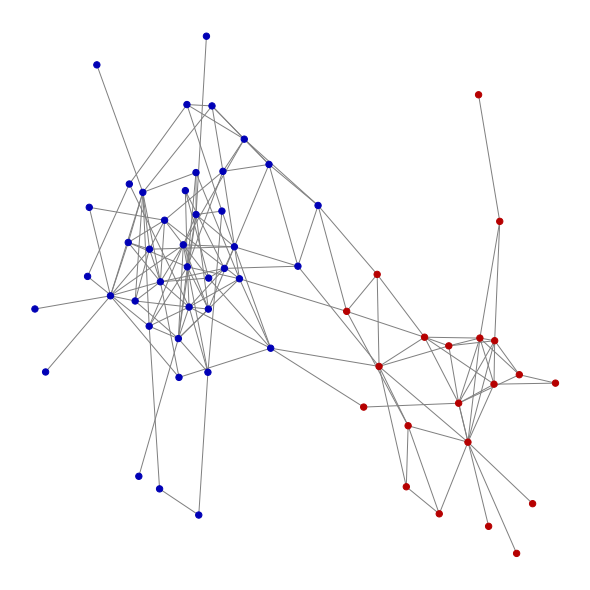

Number of clusters: 2
Time: 1.0678989887237549


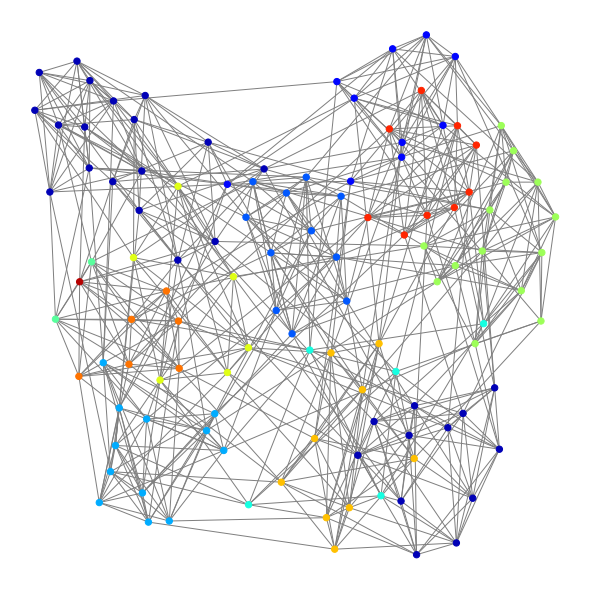

Number of clusters: 12
Time: 8.04343032836914


In [10]:
test_network(d1_k, True, './results/D1-K=2.csv')
test_network(d2_k, True, './results/D2-K=7.csv')
test_network(d3_k, True, './results/D3-K=12.csv')

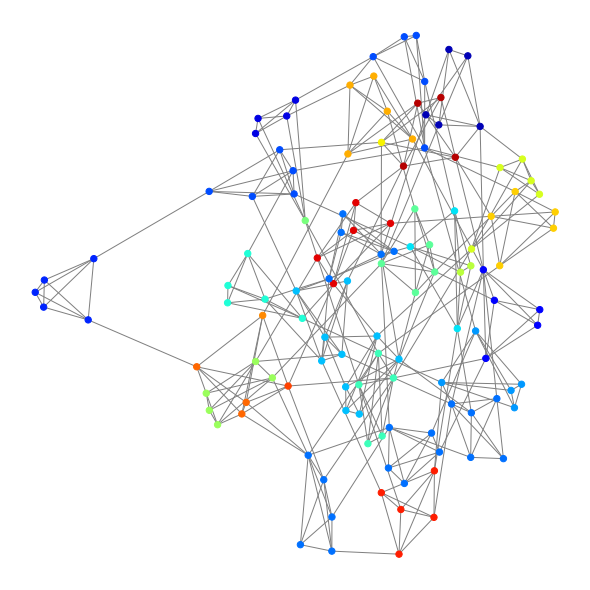

Number of clusters: 25
Time: 18.124347686767578


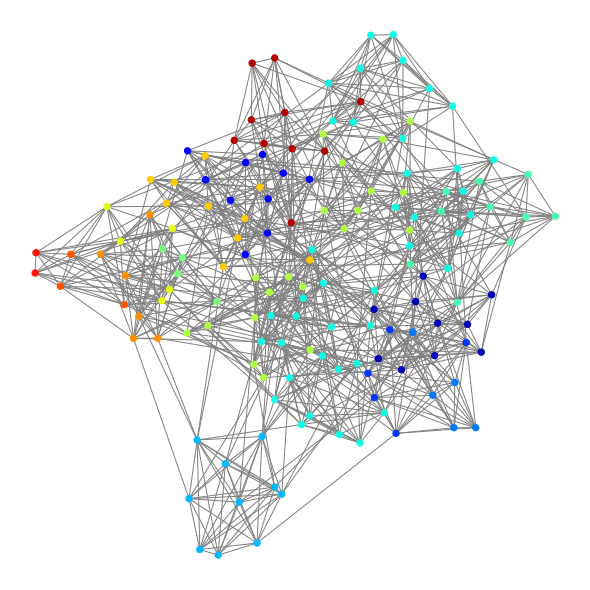

Number of clusters: 15
Time: 12.67906641960144


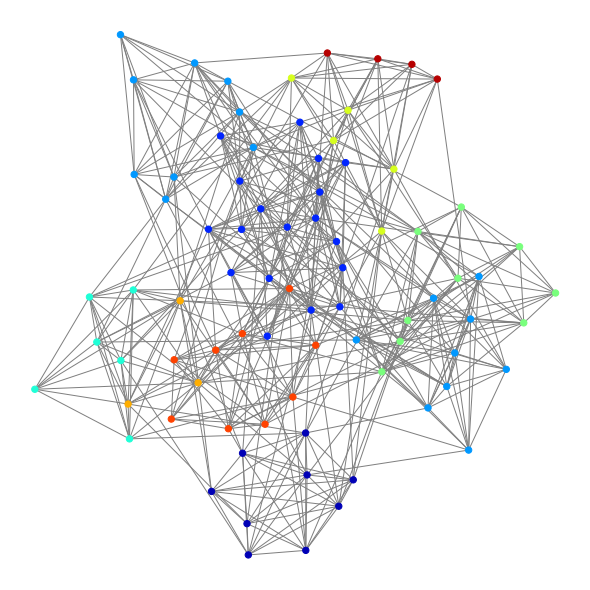

Number of clusters: 9
Time: 4.388514518737793


In [11]:
test_network(d1_unc, True, './results/D1-UNC.csv')
test_network(d2_unc, True, './results/D2-UNC.csv')
test_network(d3_unc, True, './results/D3-UNC.csv')